In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from benchmarking.plotting import plots
%matplotlib inline

In [2]:
# Helper functions for plotting.
def find_pareto(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        (before, after) = costs[:i], costs[i+1:]
        # All points such that there is no point which has at least one objective minimized better and other objectives at least equal.
        is_efficient[i] = np.all(np.logical_not(np.logical_and(np.all(before <= c, axis=1), np.any(before < c, axis=1)))) and \
                          np.all(np.logical_not(np.logical_and(np.all(after <= c, axis=1), np.any(after < c, axis=1))))
    return is_efficient

SCALE_X = {"scale_fun": lambda x: int(x / 100), "scale_label": "Hundreds of cycles"}

RESOURCES = ['bram_used', 'dsp48_used', 'ff_used', 'lut_used', 'avg_latency']

In [3]:
# Benchmark files
csv_files = ['md-knn-summary', 'md-grid-summary', 'stencil2d-inner-summary']

# Dataframes with all the data.
dfs = { bench_name : pd.read_csv(f"data/{bench_name}.csv") for bench_name in csv_files }

# Calculate average latencies for each benchmark.
for key in csv_files:
    dfs[key]['avg_latency'] = ((dfs[key]['min_latency'] + dfs[key]['max_latency']) /  2)

In [4]:


# sns.set()
def lut_res_plot(
    data, 
    keys, 
    to_save=None, 
    name="", 
    legend="xxx", 
    both=False, 
    xproc=lambda x: int(x / 10 ** 3), 
    xlabel='thousands of ', 
    title='XXX', 
    show_title=False):
    
    opts = find_pareto(data[RESOURCES].to_numpy())
    pareto = data.iloc[opts]
    print(f"[Qualitative Study] Number of pareto points for {name}: {len(pareto)}/{len(data)}")

    for key in keys:
        num = len(data[key].unique())
        pal = sns.color_palette('cubehelix_r', num)
        fig = plt.figure()
        plt.grid()
        ax = fig.gca()
        for idx, val in enumerate(sorted(data[key].unique())):
            sns.scatterplot(
                x='avg_latency', 
                y='lut_used', 
                data=pareto[pareto[key] == val], 
                rasterized=True, 
                label=str(val), 
                color=pal[idx], 
                ax=ax, 
                s=110)
            
        if key != to_save:
            ax.legend(title=key, fontsize=13)
        else:
            ax.legend(title=legend, fontsize=13).set_title(legend, prop={'size':14})
        ax.set_title(title)
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(xproc(x), ',')))
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.set_xlabel(f'Estimated latency ({xlabel}cycles)', fontsize=13)
        if show_title:
            ax.set_ylabel('Estimate LUTs', fontsize=12)
        else:
            ax.set_ylabel('')
        ax.tick_params(labelsize=11)
        if key == to_save:
            print(name)
            fig.savefig(f'dahlia-dse-{name}.pdf', dpi=600, tight_layout=True)

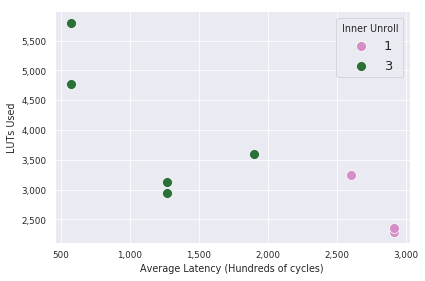

In [5]:
df = dfs['stencil2d-inner-summary']
res = 'ur_loop2'

opts = find_pareto(df[RESOURCES].to_numpy())
pareto = df.iloc[opts]

def group(idx):
    return df.iloc[idx][res]

plots.make_qual_plot(
    pareto,
    x_data = {'key': 'avg_latency', 'label': 'Average Latency'},
    y_data = {'key': 'lut_used', 'label': 'LUTs Used'},
    group_by = group,
    legend="Inner Unroll",
    fig_prefix = "stencil-inner-2d-inner-unroll",
    scale_x = SCALE_X,
)

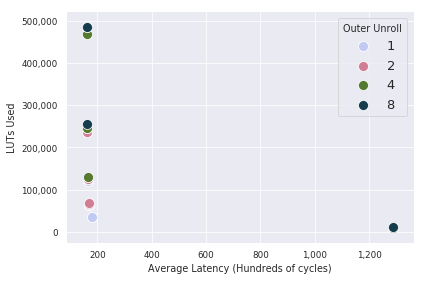

In [6]:
def plot_md_knn_with_outliers():
    df = dfs['md-knn-summary']
    res = 'ur_loop1'

    opts = find_pareto(df[RESOURCES].to_numpy())
    pareto = df.iloc[opts]

    def group(idx):
        return df.iloc[idx][res]

    plots.make_qual_plot(
        pareto,
        x_data = {'key': 'avg_latency', 'label': 'Average Latency'},
        y_data = {'key': 'lut_used', 'label': 'LUTs Used'},
        group_by = group,
        legend="Outer Unroll",
        fig_prefix = "md-knn-outer-unroll-with-outliers",
        scale_x = SCALE_X,
    )
    
plot_md_knn_with_outliers()

## Removing outliers from md_knn

In the graph above, the points on the extreme right trade-off a lot of latency for reducing the LUT count by a bit. In the paper, we decided to not show these points **but we explicitly call this out in the prose of the paper**.

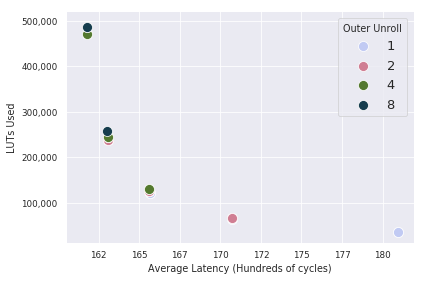

In [7]:
def plot_md_knn():
    df = dfs['md-knn-summary']
    df = df[df.avg_latency < 100000].reset_index()
    res = 'ur_loop1'

    opts = find_pareto(df[RESOURCES].to_numpy())
    pareto = df.iloc[opts]
    
    def group(idx):
        return df.iloc[idx][res]
            
    plots.make_qual_plot(
        pareto,
        x_data = {'key': 'avg_latency', 'label': 'Average Latency'},
        y_data = {'key': 'lut_used', 'label': 'LUTs Used'},
        group_by = group,
        legend='Outer Unroll',
        fig_prefix = "md-knn-outer-unroll",
        scale_x = SCALE_X,
    )

plot_md_knn()

## Only outliers in md-knn

While not reported in the original submission, it is interesting to note that the outliers only graph has a similar banding effect to the graph above.

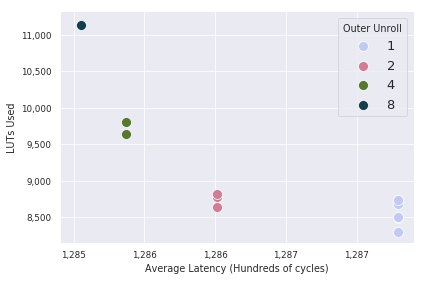

In [8]:
def plot_md_knn_only_outliers():
    df = dfs['md-knn-summary']
    df = df[df.avg_latency > 100000].reset_index()
    res = 'ur_loop1'

    opts = find_pareto(df[RESOURCES].to_numpy())
    pareto = df.iloc[opts]
    
    def group(idx):
        return df.iloc[idx][res]
            
    plots.make_qual_plot(
        pareto,
        x_data = {'key': 'avg_latency', 'label': 'Average Latency'},
        y_data = {'key': 'lut_used', 'label': 'LUTs Used'},
        group_by = group,
        legend='Outer Unroll',
        fig_prefix = "md-knn-outer-unroll-only-outliers",
        scale_x = SCALE_X,
    )

plot_md_knn_only_outliers()

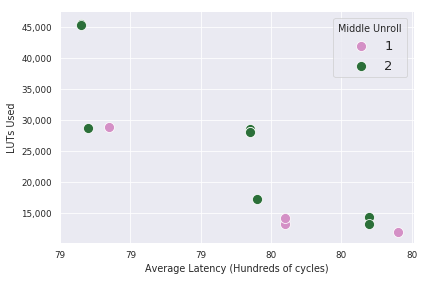

In [9]:
def plot_md_grid():
    df = dfs['md-grid-summary']
    res = 'B0Y_UR'

    opts = find_pareto(df[RESOURCES].to_numpy())
    pareto = df.iloc[opts]

    def group(idx):
        return df.iloc[idx][res]

    plots.make_qual_plot(
        pareto,
        x_data = {'key': 'avg_latency', 'label': 'Average Latency'},
        y_data = {'key': 'lut_used', 'label': 'LUTs Used'},
        group_by = group,
        legend="Middle Unroll",
        fig_prefix = "md-grid-middle-unroll",
        scale_x = SCALE_X,
    )
    
plot_md_grid()